11.3 Report

The report should be in ipynb form. It should include:
• Title

• Introduction (including the problem and motivation)

• Experiment (including the coding and the discussion of empirical results)

• Conclusions


11.4 Presentation

• Each team will present their final project

• A presentation should be no longer than 10 minutes (and no shorter than 8 minutes), and
will be followed by a Q & A session (no longer than 2 minutes)

• All team members should present

<b>

<p>
<center>
<font size="5">
Final Project (DATS 6202 - O10), Spring 2019
</font>
</center>
</p>

<p>
<center>
<font size="4">
Earthquake Prediction
</font>
</center>
</p>

<p>
<center>
<font size="3">
Data Science, Columbian College of Arts & Sciences, George Washington University
</font>
</center>
</p>

<p>
<center>
<font size="3">
Author: Elie Tetteh-Wayoe, Mihir Gadgil and Poornima Joshi
</font>
</center>
</p>

</b>

## Introduction

Problem and Motivation:

Forecasting earthquakes is one of the most important challenges in Earth science because
of their devastating consequences. Current scientific studies related to earthquake
forecasting focus on three key points: when the event will occur, where it will occur, and how
large it will be. Los Alamos National Laboratory is hosting a Kaggle competition to further
this research.

In this competition, the aim is to address when the earthquake will take place. Specifically,
predict the time remaining before laboratory earthquakes occur from real-time seismic data.
The challenge is that the data has only one feature and target to work with. The
‘acoustic_data’ is the feature and ‘time_to_failure’ is the target. Creating multiple sensible
features from the available data will be a core part of the project.

If this challenge is solved and the physics are ultimately shown to scale from the laboratory
to the field, researchers will have the potential to improve earthquake hazard assessments
that could save lives and billions of dollars in infrastructure.

## Experiment

In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from os import listdir
from os.path import isfile
import os
import matplotlib.pyplot as plt
%matplotlib inline

# Set Pandas precision
pd.set_option('display.precision', 9)

### EDA

In [16]:
# What kind of data do we have
print(os.listdir("../Earthquake-Predictions/data/"))

['.DS_Store', 'test', 'LANL-Earthquake-Prediction.zip', 'test.zip', '.gitignore', 'train.csv', 'sample_submission.csv']


In [22]:
# How does the data look like 

z = pd.read_csv("data/train.csv", nrows=5)
print("The data looks like this :")
z.head()

The data looks like this :


,acoustic_data,time_to_failure
0,12,1.469099983
1,6,1.469099982
2,8,1.469099981
3,5,1.469099980
4,8,1.469099979


In [23]:
# Look at how big our data is
df_length = 0
for training in pd.read_csv('data/train.csv', chunksize=150000):
    df_length = df_length + len(training)
    
print("Train has: rows: {} ".format(df_length))

# It has 629,145,480 number of rows

Train has: rows:629145480


In [4]:
%%time
df_train = pd.DataFrame(columns=['acoustic_data', 'time_to_failure'], dtype=np.float)

for train in pd.read_csv('data/train.csv', chunksize=150000):
    df_train = df_train.append(train[::50])
    
#     np.append(train_acoustic_data_small, train['acoustic_data'].values[::50])
#     np.append(train_time_to_failure_small, train['time_to_failure'].values[::50])


CPU times: user 12min 52s, sys: 9min 9s, total: 22min 2s
Wall time: 22min 10s


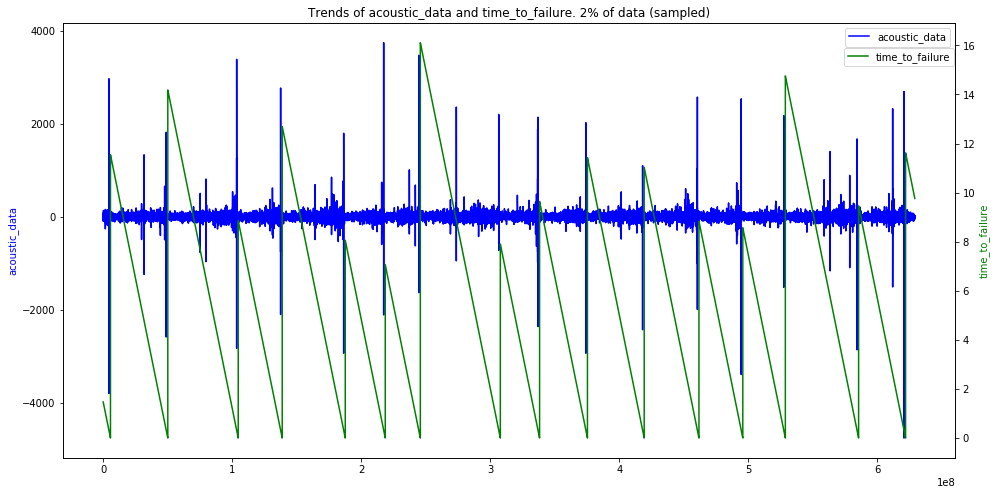

In [5]:
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of acoustic_data and time_to_failure. 2% of data (sampled)")
plt.plot(df_train['acoustic_data'], color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(df_train['time_to_failure'], color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

In [25]:
#df_train = pd.DataFrame(dtype=np.float, columns=['mean', 'std', 'min', 'max', 'sum', 'abs_mean', 'abs_std', 'abs_max', 'abs_sum', 'mean_change_abs', 'mean_change_rate', 'abs_min', 'max_to_min', 'max_to_min_diff','count_big',  'q95', 'q99', 'q05', 'abs_q01', 'xc', 'zc', 'realFFT', 'imagFFT', 'Rmean', 'Rstd', 'Rmax', 'Rmin', 'Imean', 'Istd', 'Imax', 'Imin', 'mad', 'kurt', 'skew', 'med', 'iqr', 'q999', 'q001'])

df_train = pd.DataFrame(dtype=np.float, columns=['mean', 'std', 'min', 'max', 'sum', 'abs_mean', 'abs_std', 'abs_max', 'abs_sum', 'mean_change_abs', 'mean_change_rate', 'abs_min', 'max_to_min', 'max_to_min_diff','count_big',  'q95', 'q99', 'q05', 'abs_q01', 'mad', 'kurt', 'skew', 'med', 'iqr', 'q999', 'q001'])



In [26]:
def generate_features(chunk):
    mean = chunk['acoustic_data'].mean()
    std = chunk['acoustic_data'].std()
    min = chunk['acoustic_data'].min()
    max = chunk['acoustic_data'].max()
    sum = chunk['acoustic_data'].sum()
    abs_sum = chunk['acoustic_data'].abs().sum()
    abs_max = chunk['acoustic_data'].abs().max()
    abs_mean = chunk['acoustic_data'].abs().mean()
    abs_std = chunk['acoustic_data'].abs().std()
    
    x = chunk['acoustic_data']
    mean_change_abs = np.mean(np.diff(x))
    mean_change_rate = np.mean(np.nonzero((np.diff(x) / x[:-1]))[0])
    #abs_max = np.abs(x).max()
    abs_min = np.abs(x).min()
    
#     std_first_50000 = x[:50000].std()
#     std_last_50000 = x[-50000:].std()
#     std_first_10000 = x[:10000].std()
#     std_last_10000 = x[-10000:].std()
    
#     avg_first_50000 = x[:50000].mean()
#     avg_last_50000 = x[-50000:].mean()
#     avg_first_10000 = x[:10000].mean()
#     avg_last_10000 = x[-10000:].mean()
    
#     min_first_50000 = x[:50000].min()
#     min_last_50000 = x[-50000:].min()
#     min_first_10000 = x[:10000].min()
#     min_last_10000 = x[-10000:].min()
    
#     max_first_50000 = x[:50000].max()
#     max_last_50000 = x[-50000:].max()
#     max_first_10000 = x[:10000].max()
#     max_last_10000 = x[-10000:].max()
    
    max_to_min = x.max() / np.abs(x.min())
    max_to_min_diff = x.max() - np.abs(x.min())
    count_big = len(x[np.abs(x) > 500])
    
#     mean_change_rate_first_50000 = np.mean(np.nonzero((np.diff(x[:50000]) / x[:50000][:-1]))[0])
#     mean_change_rate_last_50000 = np.mean(np.nonzero((np.diff(x[-50000:]) / x[-50000:][:-1]))[0])
#     mean_change_rate_first_10000 = np.mean(np.nonzero((np.diff(x[:10000]) / x[:10000][:-1]))[0])
#     mean_change_rate_last_10000 = np.mean(np.nonzero((np.diff(x[-10000:]) / x[-10000:][:-1]))[0])
    
    q95 = np.quantile(x, 0.95)
    q99 = np.quantile(x, 0.99)
    q05 = np.quantile(x, 0.05)
    q01 = np.quantile(x, 0.01)
    
    abs_q95 = np.quantile(np.abs(x), 0.95)
    abs_q99 = np.quantile(np.abs(x), 0.99)
    abs_q05 = np.quantile(np.abs(x), 0.05)
    abs_q01 = np.quantile(np.abs(x), 0.01)
    
    
    #FFT transform values
#     xc = pd.Series(chunk['acoustic_data'].values)
#     zc = np.fft.fft(xc)
#     realFFT = np.real(zc)
#     imagFFT = np.imag(zc)
#     Rmean = realFFT.mean()
#     Rstd = realFFT.std()
#     Rmax = realFFT.max()
#     Rmin = realFFT.min()
#     Imean = imagFFT.mean()
#     Istd = imagFFT.std()
#     Imax = imagFFT.max()
#     Imin = imagFFT.min()
    
    mad = x.mad()
    kurt = x.kurtosis()
    skew = x.skew()
    med = x.median()
    
    #Hilbert_mean = np.abs(hilbert(x)).mean()
    
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    q999 = np.quantile(x,0.999)
    q001 = np.quantile(x,0.001)
    
    
    #return [mean, std, min, max, sum, abs_mean, abs_std, abs_max, abs_sum, mean_change_abs, mean_change_rate, abs_min, max_to_min, max_to_min_diff,count_big,  q95, q99, q05, abs_q01, xc, zc, realFFT, imagFFT, Rmean, Rstd, Rmax, Rmin, Imean, Istd, Imax, Imin, mad, kurt, skew, med, iqr, q999, q001]


    return [mean, std, min, max, sum, abs_mean, abs_std, abs_max, abs_sum, mean_change_abs, mean_change_rate, abs_min, max_to_min, max_to_min_diff,count_big,  q95, q99, q05, abs_q01, mad, kurt, skew, med, iqr, q999, q001]




In [27]:
i = 0
for chunk in pd.read_csv('data/train.csv', chunksize=150000):
    time_to_failure = chunk['time_to_failure'].values[-1]
    df_train.loc[i, ['mean', 'std', 'min', 'max', 'sum', 'abs_mean', 'abs_std', 'abs_max', 'abs_sum', 'mean_change_abs', 'mean_change_rate', 'abs_min', 'max_to_min', 'max_to_min_diff','count_big',  'q95', 'q99', 'q05', 'abs_q01', 'mad', 'kurt', 'skew', 'med', 'iqr', 'q999', 'q001']] = generate_features(chunk)
    df_train.loc[i, 'time_to_failure'] = time_to_failure
    
#     df_train.loc[i, ['mean', 'std', 'min', 'max', 'sum', 'abs_mean', 'abs_std', 'abs_max', 'abs_sum', 'mean_change_abs', 'mean_change_rate', 'abs_min', 'max_to_min', 'max_to_min_diff','count_big',  'q95', 'q99', 'q05', 'abs_q01', 'xc', 'zc', 'realFFT', 'imagFFT', 'Rmean', 'Rstd', 'Rmax', 'Rmin', 'Imean', 'Istd', 'Imax', 'Imin', 'mad', 'kurt', 'skew', 'med', 'iqr', 'q999', 'q001']] = generate_features(chunk)
#     df_train.loc[i, 'time_to_failure'] = time_to_failure
    
    i += 1

In [89]:
df.head()

,acoustic_data
0,6
1,6
2,6
3,2
4,1


In [28]:
df_train.describe()

,mean,std,min,max,sum,abs_mean,abs_std,abs_max,abs_sum,mean_change_abs,...,q05,abs_q01,mad,kurt,skew,med,iqr,q999,q001,time_to_failure
count,4195.000000000,4195.000000000,4195.000000000,4195.000000000,4195.000000000,4195.000000000,4195.000000000,4195.000000000,4.195000000e+03,4195.000000000,...,4195.000000000,4195.0,4195.000000000,4195.000000000,4195.000000000,4195.000000000,4195.000000000,4195.000000000,4195.000000000,4195.000000000
mean,4.519475158,6.547788191,-149.190941597,163.522288439,677807.531823599,5.547366504,5.750164895,170.046245530,8.319850017e+05,-0.000000160,...,-2.184779499,0.0,3.482898994,68.297997079,0.125830202,4.527294398,4.659356377,57.292155423,-47.921710846,5.683670383
std,0.256049486,8.503939490,265.087983548,272.930331447,39087.639872457,1.517037556,8.339211436,296.887014915,2.277461406e+05,0.000060189,...,2.346558457,0.0,1.621137541,70.532565013,0.477901197,0.499313977,0.718350695,95.524470853,97.166689941,3.673246303
min,3.596313333,2.802720142,-5515.000000000,23.000000000,207622.000000000,4.147706667,2.589085218,23.000000000,2.189980000e+05,-0.000860006,...,-39.000000000,0.0,2.199320765,0.648601728,-4.091826221,4.000000000,3.000000000,15.000000000,-1726.002000000,0.006397657
25%,4.349496667,4.478637142,-154.000000000,92.000000000,652414.000000000,5.061843333,3.862810034,94.000000000,7.592765000e+05,-0.000020000,...,-3.000000000,0.0,2.820130084,28.090227382,-0.040779005,4.000000000,4.000000000,36.000000000,-50.000000000,2.635348205
50%,4.522146667,5.618797775,-111.000000000,123.000000000,678274.000000000,5.380853333,4.781513433,127.000000000,8.071280000e+05,0.000000000,...,-2.000000000,0.0,3.324506301,45.816624914,0.085619831,5.000000000,5.000000000,46.001000000,-37.000000000,5.358795935
75%,4.693350000,6.880903553,-79.000000000,170.000000000,704002.500000000,5.748553333,5.887947258,175.000000000,8.622830000e+05,0.000026667,...,-1.000000000,0.0,3.805474741,78.664201991,0.253930302,5.000000000,5.000000000,59.001000000,-26.001000000,8.177499733
max,5.391993333,153.703569356,-15.000000000,5444.000000000,808799.000000000,32.762073333,150.432368254,5515.000000000,4.914311000e+06,0.000740005,...,0.000000000,0.0,31.724965651,631.158926835,4.219428824,5.000000000,13.000000000,1790.000000000,-5.000000000,16.103195567


In [29]:
df_train.head()

,mean,std,min,max,sum,abs_mean,abs_std,abs_max,abs_sum,mean_change_abs,...,q05,abs_q01,mad,kurt,skew,med,iqr,q999,q001,time_to_failure
0,4.884113333,5.101106131,-98.0,104.0,732617.0,5.576566667,4.333324674,104.0,836485.0,-0.000080001,...,-2.0,0.0,3.263401357,33.662481293,-0.024061167,5.0,4.0,40.000,-30.0,1.430797186
1,4.725766667,6.588823782,-154.0,181.0,708865.0,5.734166667,5.732776966,181.0,860125.0,0.000000000,...,-2.0,0.0,3.574301851,98.758517179,0.390560504,5.0,5.0,59.000,-47.0,1.391498893
2,4.906393333,6.967397034,-106.0,140.0,735959.0,6.152646667,5.895944714,140.0,922897.0,-0.000013333,...,-3.0,0.0,3.948411362,33.555211407,0.217390561,5.0,5.0,59.000,-47.0,1.353196095
3,4.902240000,6.922305187,-199.0,197.0,735336.0,5.933960000,6.061213600,199.0,890094.0,0.000000000,...,-2.0,0.0,3.647117069,116.548171688,0.757277536,5.0,5.0,60.001,-50.0,1.313797802
4,4.908720000,7.301110190,-126.0,145.0,736308.0,6.110586667,6.329485314,145.0,916588.0,-0.000006667,...,-2.0,0.0,3.826051623,52.977904834,0.064531069,5.0,5.0,65.000,-56.0,1.274399509


In [30]:
df_train.isna().sum()

mean                0
std                 0
min                 0
max                 0
sum                 0
abs_mean            0
abs_std             0
abs_max             0
abs_sum             0
mean_change_abs     0
mean_change_rate    0
abs_min             0
max_to_min          0
max_to_min_diff     0
count_big           0
q95                 0
q99                 0
q05                 0
abs_q01             0
mad                 0
kurt                0
skew                0
med                 0
iqr                 0
q999                0
q001                0
time_to_failure     0
dtype: int64

In [31]:
X_train = df_train.drop(columns=['time_to_failure']).values
y_train = df_train['time_to_failure'].values

In [32]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)

In [33]:
model = keras.Sequential([
    layers.Dense(100, activation=tf.nn.relu, input_shape=[X_train.shape[1]]),
    layers.Dense(100, activation=tf.nn.relu),
    layers.Dense(1)
])

optimizer = keras.optimizers.RMSprop(0.001)

model.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=['mean_absolute_error', 'mean_squared_error'])

In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               2700      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 12,901
Trainable params: 12,901
Non-trainable params: 0
_________________________________________________________________


In [35]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print('')
        print('.', end='')

EPOCHS = 1000
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS, validation_split=0.2, verbose=0,
    callbacks=[early_stop, PrintDot()]
)


.............

In [36]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
8,11.952176482,2.639885716,11.952176482,6.971222569,2.034481313,6.971222569,8
9,11.524503840,2.598206788,11.524503840,6.944088171,2.025834257,6.944088171,9
10,12.298293645,2.678045553,12.298293645,6.893383629,2.014483817,6.893383629,10
11,11.870397229,2.625649191,11.870397229,6.851273799,2.016060251,6.851273799,11
12,12.733147272,2.742183455,12.733147272,6.851327364,2.015579700,6.851327364,12


In [37]:
path = 'data/test/'
files = [f[:-4] for f in listdir(path) if isfile(path + f)]

In [38]:
predictions = pd.DataFrame(index=files, dtype=np.float, columns=['time_to_failure'])
predictions.index.name = 'seg_id'

In [42]:
for f in files:
    if f.startswith("seg_"):
        df = pd.read_csv(path+f+'.csv')
        df_test = pd.DataFrame(np.array(generate_features(df)).reshape(1,-1), columns=['mean', 'std', 'min', 'max', 'sum', 'abs_mean', 'abs_std', 'abs_max', 'abs_sum', 'mean_change_abs', 'mean_change_rate', 'abs_min', 'max_to_min', 'max_to_min_diff','count_big',  'q95', 'q99', 'q05', 'abs_q01', 'mad', 'kurt', 'skew', 'med', 'iqr', 'q999', 'q001'])
        X_test = df_test.values
        X_test = ss.transform(X_test)
        y = model.predict(X_test)[0]
        predictions.loc[f, 'time_to_failure'] = y

In [43]:
predictions.to_csv('submission.csv')

# ELASTIC NET

In [77]:
from sklearn.linear_model import ElasticNet
alpha = 0.1
enet = ElasticNet(alpha=alpha)
y_pred_enet = enet.fit(X_train, y_train)

In [79]:
pred = pd.DataFrame(index=files, dtype=np.float, columns=['time_to_failure'])
pred.index.name = 'seg_id'

In [83]:
for f in files:
    if f.startswith("seg_"):
        df = pd.read_csv(path+f+'.csv')
        df_test = pd.DataFrame(np.array(generate_features(df)).reshape(1,-1), columns=['mean', 'std', 'min', 'max', 'sum', 'abs_mean', 'abs_std', 'abs_max', 'abs_sum', 'mean_change_abs', 'mean_change_rate', 'abs_min', 'max_to_min', 'max_to_min_diff','count_big',  'q95', 'q99', 'q05', 'abs_q01', 'mad', 'kurt', 'skew', 'med', 'iqr', 'q999', 'q001'])
        X_test = df_test.values
        X_test = ss.transform(X_test)
        y = y_pred_enet.predict(X_test)[0]
        pred.loc[f, 'time_to_failure'] = y
        pred = pred.dropna()
        

In [84]:
pred.to_csv('submission.csv')

In [85]:
pred.head()

,time_to_failure
seg_id,
seg_51f0a2,4.948358486
seg_de98fa,3.813757797
seg_ad82ca,7.257883536
seg_e3ca24,7.062237250
seg_64f8dc,6.289204239
